# Modules

In [360]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [361]:
import sys

import urllib.request
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
import matplotlib
import plotly.graph_objects as go
import seaborn as sns

from IPython.display import display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

sys.path.append('..')
from src import config, data, model

plt.rcParams.update(plt.rcParamsDefault)
plt.style.use(['ggplot', 'bmh'])
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

display_settings = {
    'max_columns': 999,
    'expand_frame_repr': True,
    'max_rows': 999,
    'precision': 4,
    'show_dimensions': True
}

for op, value in display_settings.items():
    pd.set_option("display.{}".format(op), value)


%matplotlib inline

# Data

In [363]:
df = pd.read_csv(
    config.get_processed_filename(config.DATA_FILES['order'])
)

df[config.COLUMN_DATE] = df[config.COLUMN_DATE].apply(pd.to_datetime)
df = df[df['order_status'] == 'delivered']

df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,product_category_name,seller_zip_code_prefix,seller_city,seller_state,state_name,state_code,lat,long
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,47813,barreiras,BA,1,boleto,1,141.46,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.7,22.76,4,perfumery,31570.0,belo horizonte,SP,Bahia,BA,-12.5200,-41.6900
1,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,75265,vianopolis,GO,1,credit_card,3,179.12,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.9,19.22,5,auto,14840.0,guariba,SP,Goiás,GO,-15.9333,-50.1333
2,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,9195,santo andre,SP,1,credit_card,1,28.62,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.9,8.72,5,stationery,8752.0,mogi das cruzes,SP,SãoPaulo,SP,-23.5333,-46.6333
3,82566a660a982b15fb86e904c8d32918,d3e3b74c766bc6214e0c830b17ee2341,delivered,2018-06-07 10:06:19,2018-06-09 03:13:12,2018-06-11 13:29:00,2018-06-19 12:05:52,2018-07-18,35400,ouro preto,MG,1,boleto,1,50.13,1.0,72a97c271b2e429974398f46b93ae530,094ced053e257ae8cae57205592d6712,2018-06-18 03:13:12,31.9,18.23,5,perfumery,14095.0,ribeirao preto,SP,MinasGerais,MG,-19.8167,-43.9500
4,5ff96c15d0b717ac6ad1f3d77225a350,19402a48fe860416adf93348aba37740,delivered,2018-07-25 17:44:10,2018-07-25 17:55:14,2018-07-26 13:16:00,2018-07-30 15:52:25,2018-08-08,4812,sao paulo,SP,1,credit_card,3,32.70,1.0,10adb53d8faa890ca7c2f0cbcb68d777,1900267e848ceeba8fa32d80c1a5f5a8,2018-07-27 17:55:14,19.9,12.80,5,bed_bath_table,14940.0,ibitinga,SP,SãoPaulo,SP,-23.5333,-46.6333


# ARIMA model

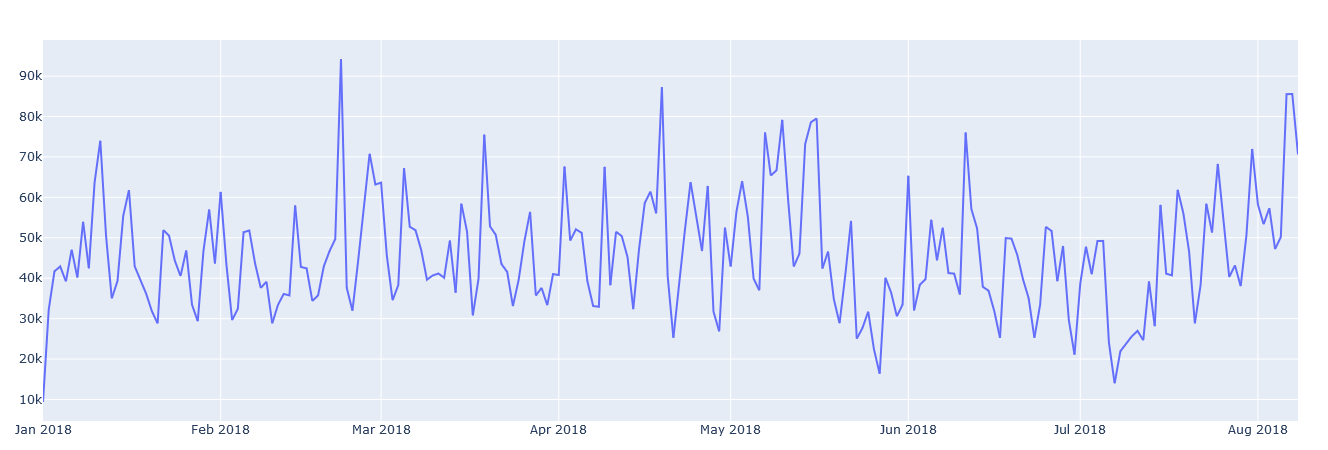

In [364]:
# plot the timeserie

df_sales = df.groupby(pd.Grouper(key='order_purchase_timestamp', freq='1D')).agg(
    revenue = ('payment_value', 'sum'),
    n_order = ('order_id', 'nunique')
).reset_index()

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df_sales['order_purchase_timestamp'], y=df_sales['revenue'],
               mode='lines',
               name='lines')
)
fig.update_layout(
    hovermode='x unified',
    autosize=True,
    margin=dict(
        l=30,
        r=30,
        b=20,
        t=40
    )
)

fig.show()

The serie seems stationary, do no need for differentiating. There might be some seasonality though.

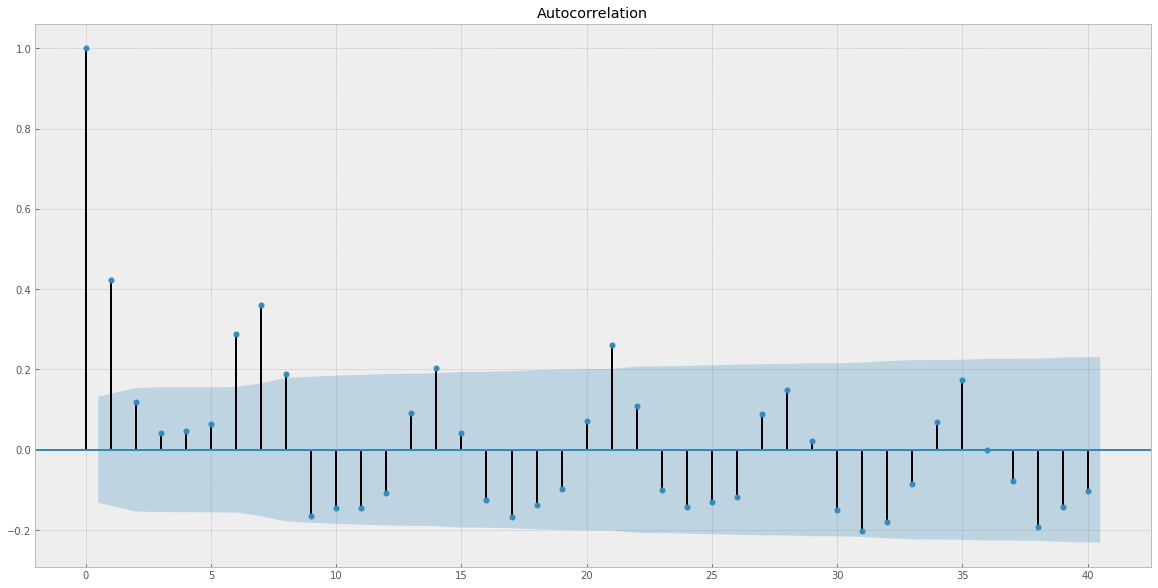

In [365]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(figsize=(20, 10))
acf = sm.graphics.tsa.plot_acf(df_sales['revenue'].values.squeeze(), lags=40, ax=ax)


The shaded area is the significance threshold: an autocorrelation value below it indicates that the autocorrelation to the corresponding lag is not statistically significant.

AIC: 4753.66


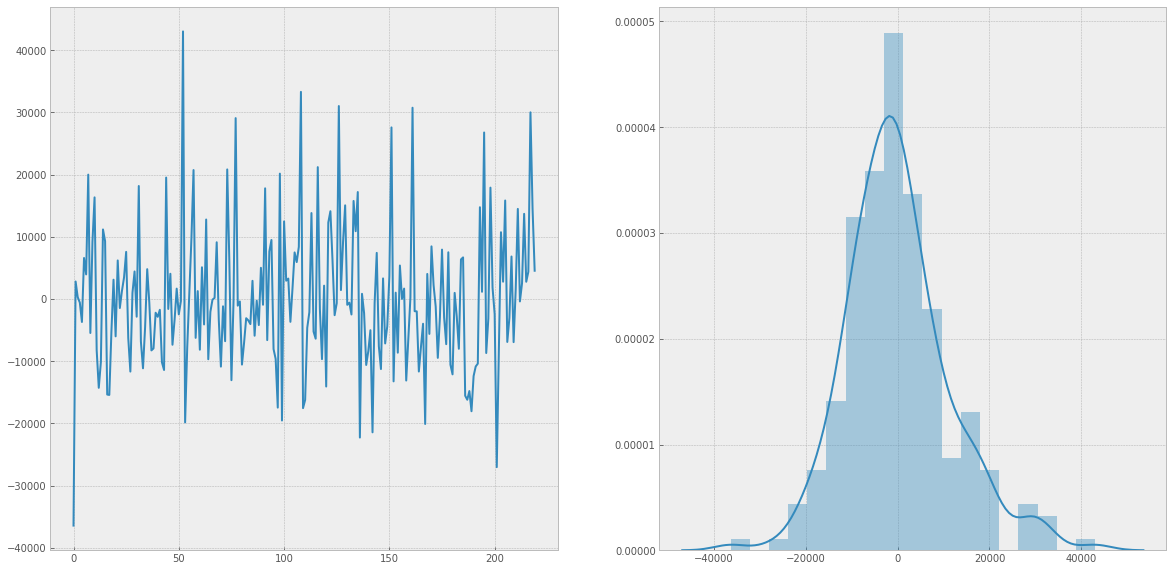

In [412]:
#df_sales = (df_sales['revenue'] - df_sales['revenue'].diff(8)).dropna()

arima = ARIMA(df_sales['revenue'].values, order=(9,0,1))
model_fit = arima.fit()

print(f"AIC: {model_fit.aic:.2f}")
residuals = model_fit.resid

f, (ax_res, ax_res_dist) = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)

ax_res.plot(residuals)
sns.distplot(residuals, ax=ax_res_dist)

It looks like there is some periodicity in the residuals meaning it exists some seasonality in the signal that is not captured by the model. Additionally, residuals distribution is not centered, indicating some bias in the model.

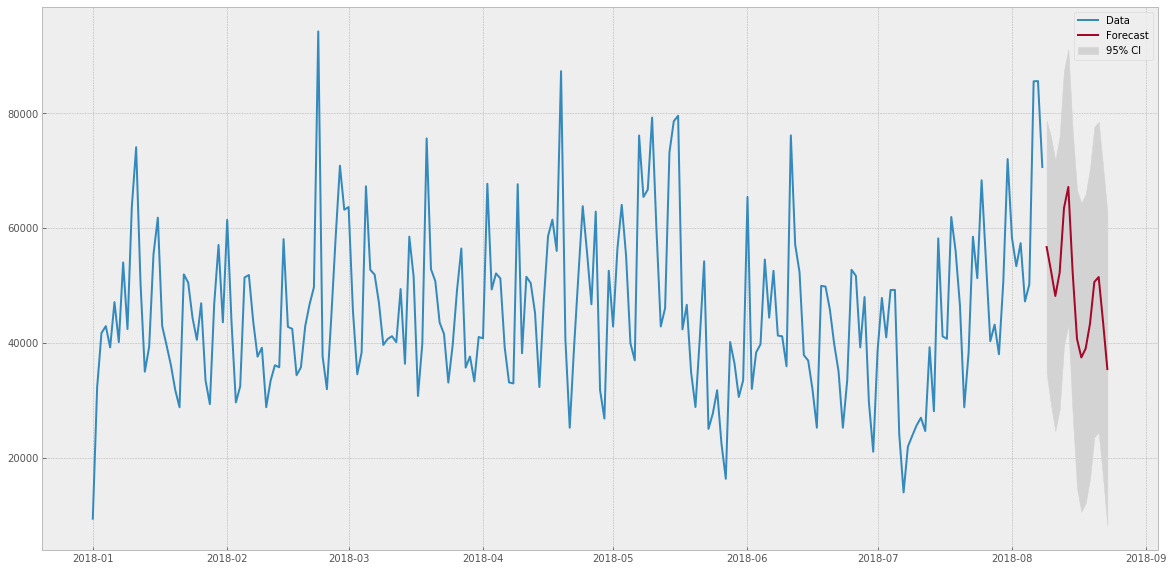

In [463]:
predictions = model.predict(df_sales['order_purchase_timestamp'], df_sales['revenue'], look_ahead=15)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df_sales['order_purchase_timestamp'], df_sales['revenue'], label='Data')
ax.fill_between(predictions['date'], predictions['ci_low'], predictions['ci_high'], label='95% CI', color='lightgray')
ax.plot(predictions['date'], predictions['forecast'], label='Forecast')

plt.legend()